In [1]:
import os, glob
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
mpl.rcParams['figure.dpi'] = 72

In [8]:
# Compare multiple days side by side
in_dir = '/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/'
zarr_files = sorted(glob.glob(f"{in_dir}/ifs_tco3999_rcbmf_3H_zoom8_*.zarr"))[:4]  # First 4 days
zarr_files

['/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr',
 '/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/ifs_tco3999_rcbmf_3H_zoom8_20200102_20200102.zarr',
 '/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/ifs_tco3999_rcbmf_3H_zoom8_20200103_20200103.zarr',
 '/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/ifs_tco3999_rcbmf_3H_zoom8_20200104_20200104.zarr']

In [9]:
ds_check = xr.open_zarr(zarr_files[0]).pipe(egh.attach_coords)
ds_check

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 8, lev: 25, cell: 786432)
Coordinates:
    lat      (cell) float64 6MB 89.82 89.82 89.82 89.82 ... -89.82 -89.82 -89.82
  * lev      (lev) int64 200B 1 5 10 20 30 50 70 ... 875 900 925 950 975 1000
    lon      (cell) float64 6MB 45.0 135.0 225.0 315.0 ... 135.0 225.0 315.0
  * time     (time) datetime64[ns] 64B 2020-01-01 ... 2020-01-01T21:00:00
    crs      int64 8B 0
  * cell     (cell) int32 3MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
Data variables: (12/15)
    hur      (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
    hus      (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
    omega    (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
    pr       (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    prw      (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    ps       (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    ...       ...
    tas      (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    ua       (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
    uas      (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    va       (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
    vas      (time, cell) float32 25MB dask.array<chunksize=(8, 262144), meta=np.ndarray>
    z        (time, lev, cell) float32 629MB dask.array<chunksize=(8, 1, 262144), meta=np.ndarray>
Attributes:
    centre:                      ecmf
    centreDescription:           European Centre for Medium-Range Weather For...
    coarsened_from_zoom:         11
    coarsening_factor:           64
    coarsening_method:           mean
    edition:                     2
    history:                     🪄🧙‍♂️🔮 magic dataset assembly provided by gr...
    processing_timestamp:        2025-11-10T11:54:38.745363
    source_catalog:              ifs_tco3999_rcbmf_zoom11
    subCentre:                   1003
    temporal_resampling_method:  subsample
    temporal_subsample_factor:   3

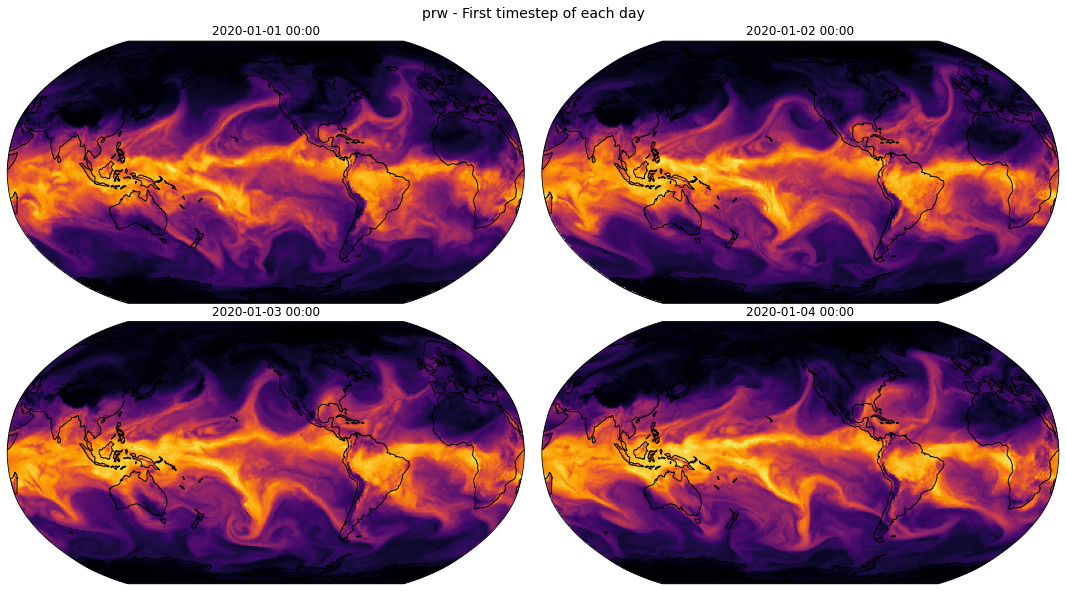

In [10]:
varname = "prw"

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)
land = cf.NaturalEarthFeature('physical', 'land', '110m')

# Loop through each day's file and plot the first timestep
for i, zarr_file in enumerate(zarr_files, 0):
    ds_check = xr.open_zarr(zarr_file).pipe(egh.attach_coords)
    itime = ds_check.time.isel(time=0).dt.strftime('%Y-%m-%d %H:%M').item()
    
    # Create subplot for each day
    ax = plt.subplot(gs[i], projection=ccrs.Robinson(central_longitude=225))
    # Set up maps: important to correctly show global maps!
    ax.set_global()
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    
    # Plot first timestep of tas (surface temperature)
    im = egh.healpix_show(ds_check[varname].isel(time=0), cmap='inferno', ax=ax)
    
    # Add time stamp
    ax.set_title(itime, fontsize=12)
    
    ds_check.close()

plt.tight_layout()
plt.suptitle(f'{varname} - First timestep of each day', fontsize=14, y=1.02)
plt.show()

# Quick Visual Check of Multiple Days

Compare data from different days to spot any anomalies

In [ ]:
def validate_zarr_file(zarr_path):
    """
    Validate a single zarr file for completeness and data quality.
    
    Returns:
        dict: Validation results with 'valid' boolean and details
    """
    results = {
        'file': zarr_path,
        'valid': True,
        'errors': [],
        'warnings': [],
        'stats': {}
    }
    
    try:
        ds = xr.open_zarr(zarr_path)
        
        # Expected variables (add 'hflsd' & 'hflsu' later)
        expected_vars = ['ua', 'va', 'omega', 'z', 'ta', 'hus', 'hur', 'pr', 'prw', 'ps', 'psl', 
                        'uas', 'vas', 'tas', 'rlut']
        
        # Check 1: All variables present
        missing_vars = [v for v in expected_vars if v not in ds.data_vars]
        if missing_vars:
            results['errors'].append(f"Missing variables: {missing_vars}")
            results['valid'] = False
        
        # Check 2: Expected dimensions (use .sizes instead of .dims to avoid FutureWarning)
        expected_dims = {'time': 8, 'lev': 25, 'cell': 786432, 'crs': 1}  # For zoom 8, 3H
        actual_sizes = dict(ds.sizes)  # Convert to regular dict
        
        for dim, expected_size in expected_dims.items():
            if dim not in actual_sizes:
                results['errors'].append(f"Missing dimension: {dim}")
                results['valid'] = False
            elif actual_sizes[dim] != expected_size:
                # Time dimension might vary for last day of dataset
                if dim == 'time' and abs(actual_sizes[dim] - expected_size) <= 1:
                    results['warnings'].append(
                        f"Time dimension is {actual_sizes[dim]} (expected {expected_size})"
                    )
                else:
                    results['errors'].append(
                        f"Dimension {dim} size is {actual_sizes[dim]} (expected {expected_size})"
                    )
                    results['valid'] = False
        
        # Check 3: Data validity for each variable
        for var in [v for v in expected_vars if v in ds.data_vars]:
            data = ds[var]
            
            # Check for all NaN - load a small sample first to test
            try:
                # For variables with lev dimension, check if any level has data
                if 'lev' in data.dims:
                    # Check first timestep, all levels
                    sample = data.isel(time=0).compute()
                    all_nan = sample.isnull().all().item()
                else:
                    # For 2D variables, check first timestep
                    sample = data.isel(time=0).compute()
                    all_nan = sample.isnull().all().item()
                
                if all_nan:
                    results['errors'].append(f"Variable {var}: ALL values are NaN")
                    results['valid'] = False
                    continue
                
                # Calculate NaN percentage more carefully
                total_size = data.size
                # Use isnull().sum() which is more efficient
                nan_count = float(data.isnull().sum().compute())
                nan_pct = (nan_count / total_size) * 100
                
                if nan_pct > 50:
                    results['errors'].append(
                        f"Variable {var}: {nan_pct:.1f}% NaN values"
                    )
                    results['valid'] = False
                elif nan_pct > 0:
                    results['warnings'].append(
                        f"Variable {var}: {nan_pct:.1f}% NaN values"
                    )
                
                # Get min/max values (nanmin/nanmax ignore NaN)
                min_val = float(data.min().compute())
                max_val = float(data.max().compute())
                results['stats'][var] = {'min': min_val, 'max': max_val, 'nan_pct': nan_pct}
                
                # Check for extreme values (inf, very large numbers)
                if not np.isfinite(min_val) or not np.isfinite(max_val):
                    results['errors'].append(
                        f"Variable {var}: Non-finite values detected"
                    )
                    results['valid'] = False
                    
            except Exception as e:
                results['errors'].append(f"Variable {var}: Error checking data - {str(e)}")
                results['valid'] = False
        
        # Check 4: Time coordinate validity
        if 'time' in ds.coords:
            time_vals = pd.to_datetime(ds.time.values)
            if not time_vals.is_monotonic_increasing:
                results['errors'].append("Time coordinate is not monotonic increasing")
                results['valid'] = False
            
            if len(time_vals) > 1:
                time_deltas = np.diff(time_vals.astype('int64')) / 1e9 / 3600  # hours
                expected_delta = 3.0  # 3-hourly
                if not np.allclose(time_deltas, expected_delta, atol=0.1):
                    results['warnings'].append(
                        f"Time spacing irregular: mean={time_deltas.mean():.2f}h"
                    )
        
        ds.close()
        
    except Exception as e:
        results['valid'] = False
        results['errors'].append(f"Failed to open/read file: {str(e)}")
    
    return results


def validate_all_zarr_files(directory, start_date=None, end_date=None, pattern='*.zarr'):
    """
    Validate all zarr files in a directory.
    
    Args:
        directory: Path to directory containing zarr files
        start_date: Optional start date to filter (YYYY-MM-DD)
        end_date: Optional end date to filter (YYYY-MM-DD)
        pattern: Glob pattern for zarr files
    
    Returns:
        pd.DataFrame: Summary of validation results
    """
    zarr_files = sorted(glob.glob(f"{directory}/{pattern}"))
    
    if not zarr_files:
        print(f"No zarr files found in {directory}")
        return None
    
    print(f"Found {len(zarr_files)} zarr files to validate...")
    
    results = []
    for i, zarr_file in enumerate(zarr_files, 1):
        print(f"[{i}/{len(zarr_files)}] Validating {os.path.basename(zarr_file)}...", end=' ')
        result = validate_zarr_file(zarr_file)
        results.append(result)
        
        if result['valid']:
            print("✅ VALID")
        else:
            print(f"❌ INVALID ({len(result['errors'])} errors)")
    
    # Create summary DataFrame
    summary_data = []
    for r in results:
        basename = os.path.basename(r['file'])
        summary_data.append({
            'file': basename,
            'valid': r['valid'],
            'num_errors': len(r['errors']),
            'num_warnings': len(r['warnings']),
            'errors': '; '.join(r['errors']) if r['errors'] else '',
            'warnings': '; '.join(r['warnings']) if r['warnings'] else ''
        })
    
    df = pd.DataFrame(summary_data)
    
    # Print summary
    print("\n" + "="*80)
    print("VALIDATION SUMMARY")
    print("="*80)
    print(f"Total files: {len(results)}")
    print(f"Valid files: {df['valid'].sum()}")
    print(f"Invalid files: {(~df['valid']).sum()}")
    
    if (~df['valid']).any():
        print("\n⚠️  INVALID FILES:")
        print(df[~df['valid']][['file', 'errors']])
    
    if df['num_warnings'].sum() > 0:
        print(f"\nFiles with warnings: {(df['num_warnings'] > 0).sum()}")
    
    return df, results

In [4]:
# Validate all zarr files
validation_df, validation_results = validate_all_zarr_files(in_dir)
validation_df

Found 5 zarr files to validate...
[1/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr... ❌ INVALID (2 errors)
[2/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200102_20200102.zarr... ❌ INVALID (2 errors)
[2/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200102_20200102.zarr... ✅ VALID
[3/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200103_20200103.zarr... ✅ VALID
[3/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200103_20200103.zarr... ✅ VALID
[4/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200104_20200104.zarr... ✅ VALID
[4/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200104_20200104.zarr... ✅ VALID
[5/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200105_20200105.zarr... ✅ VALID
[5/5] Validating ifs_tco3999_rcbmf_3H_zoom8_20200105_20200105.zarr... ✅ VALID

VALIDATION SUMMARY
Total files: 5
Valid files: 4
Invalid files: 1

⚠️  INVALID FILES:
                                                file  \
0  ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr   

                                      

,file,valid,num_errors,num_warnings,errors,warnings
0,ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr,False,2,0,Variable pr: ALL values are NaN; Variable rlut...,
1,ifs_tco3999_rcbmf_3H_zoom8_20200102_20200102.zarr,True,0,0,,
2,ifs_tco3999_rcbmf_3H_zoom8_20200103_20200103.zarr,True,0,0,,
3,ifs_tco3999_rcbmf_3H_zoom8_20200104_20200104.zarr,True,0,0,,
4,ifs_tco3999_rcbmf_3H_zoom8_20200105_20200105.zarr,True,0,0,,


In [5]:
validation_results[0]

{'file': '/pscratch/sd/w/wcmca1/hackathon/healpix/ifs_tco3999_rcbmf/ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr',
 'valid': False,
 'errors': ['Variable pr: ALL values are NaN',
  'Variable rlut: ALL values are NaN'],
 'warnings': [],
 'stats': {'ua': {'min': -107.53651428222656,
   'max': 202.16616821289062,
   'nan_pct': 0.0},
  'va': {'min': -157.43507385253906,
   'max': 146.95156860351562,
   'nan_pct': 0.0},
  'omega': {'min': -42.0038948059082,
   'max': 25.673725128173828,
   'nan_pct': 0.0},
  'z': {'min': -3202.29443359375, 'max': 492420.96875, 'nan_pct': 0.0},
  'ta': {'min': 175.2030029296875, 'max': 317.5815734863281, 'nan_pct': 0.0},
  'hus': {'min': 0.0, 'max': 0.022297896444797516, 'nan_pct': 0.0},
  'hur': {'min': 0.0, 'max': 142.32940673828125, 'nan_pct': 0.0},
  'prw': {'min': 0.148685023188591, 'max': 77.1600570678711, 'nan_pct': 0.0},
  'ps': {'min': 46956.78515625, 'max': 104800.75, 'nan_pct': 0.0},
  'psl': {'min': 96008.3671875, 'max': 104876.9765625, 'nan

In [6]:
# Check detailed statistics for a specific file
file_idx = 0  # Change this to inspect different files
result = validation_results[file_idx]
print(f"File: {os.path.basename(result['file'])}")
print(f"Valid: {result['valid']}")
print(f"\nVariable Statistics:")
for var, stats in result['stats'].items():
    print(f"  {var:5s}: min={stats['min']:12.4e}, max={stats['max']:12.4e}, NaN%={stats['nan_pct']:.2f}%")

File: ifs_tco3999_rcbmf_3H_zoom8_20200101_20200101.zarr
Valid: False

Variable Statistics:
  ua   : min= -1.0754e+02, max=  2.0217e+02, NaN%=0.00%
  va   : min= -1.5744e+02, max=  1.4695e+02, NaN%=0.00%
  omega: min= -4.2004e+01, max=  2.5674e+01, NaN%=0.00%
  z    : min= -3.2023e+03, max=  4.9242e+05, NaN%=0.00%
  ta   : min=  1.7520e+02, max=  3.1758e+02, NaN%=0.00%
  hus  : min=  0.0000e+00, max=  2.2298e-02, NaN%=0.00%
  hur  : min=  0.0000e+00, max=  1.4233e+02, NaN%=0.00%
  prw  : min=  1.4869e-01, max=  7.7160e+01, NaN%=0.00%
  ps   : min=  4.6957e+04, max=  1.0480e+05, NaN%=0.00%
  psl  : min=  9.6008e+04, max=  1.0488e+05, NaN%=0.00%
  uas  : min= -2.6033e+01, max=  2.6147e+01, NaN%=0.00%
  vas  : min= -3.1986e+01, max=  2.5266e+01, NaN%=0.00%
  tas  : min=  2.2143e+02, max=  3.1753e+02, NaN%=0.00%


# Comprehensive Data Validation

Check all zarr files to ensure:
1. All expected variables are present
2. All timesteps have valid (non-NaN) data
3. Data ranges are reasonable
4. File dimensions match expectations